In [1]:
##### diagnostic
from Diagnostic_functions import *

In [2]:
# t_window = 8000e-15  # total time window [s]
# ev_window = 100e-3   # total energy window [eV]
# t_res = 4/ev_window *1e-15       # time sampling resolution [s]; roughly: 10fs/pt = 400meV range

# sigT = 400e-15/2.355

t_window = 8000e-15  # total time window [s]
ev_window = 500e-3   # total energy window [eV]
t_res = 4/ev_window *1e-15       # time sampling resolution [s]; roughly: 10fs/pt = 400meV range

sigT = 100e-15/2.355

pulseRange = int(t_window/sigT)
nx = 256; ny = 256; nz = 2*int(t_window/t_res/2)
range_x = 4e-3; range_y = 4e-3
factor = -1 # factor = 0.5
d_slit = 10e-6

def rCRL(fCRL, nCRL):
    # calculates the min radius of curvature of each lens
    return 7.58227e-06*fCRL/nCRL

fCRL0 = 290.; nCRL0 = 1

# I/O
def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
dir_output = 'output/'; mkdir(dir_output)
dir_case = dir_output+'pre_mono/'; mkdir(dir_case)
dir_param = dir_case+'{}fs/'.format(round(sigT*2.355*1e15,2)); mkdir(dir_param)
dir_plot = dir_param+'{}fs_{}meV/'.format(round(t_window*1e15,1),round(ev_window*1e3,1)); mkdir(dir_plot)


drift between crystals (mm): [180.97478779 319.77349123 180.97478779]


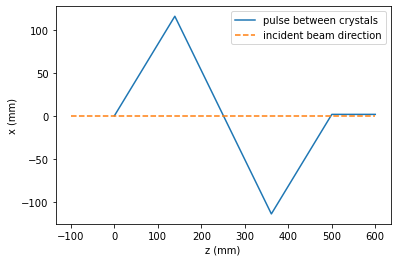

In [3]:
# calculate crystal geometry
z1 = 0      # position in lab frame [mm]
z2 = 139
z3 = 361
z4 = 500
zlist = [z1, z2, z3, z4]

posz = []
for i in range(len(zlist)):
    posz.append(300+zlist[i]/1e3)

# Si 220
C1 = srwlib.SRWLOptCryst(_d_sp=1.9201374688016222, _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                         _psi_hr=-6.610167427198717e-06, _psi_hi=1.7824173540780476e-07,
                         _psi_hbr=-6.610167427198717e-06, _psi_hbi=1.7824173540780476e-07,
                         _tc=0.01, _ang_as=0)

# Si 440
C2 = srwlib.SRWLOptCryst(_d_sp=0.9600687344008111, _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                         _psi_hr=-4.181686438547451e-06, _psi_hi=1.6100412693351052e-07,
                         _psi_hbr=-4.181686438547451e-06, _psi_hbi=1.6100412693351052e-07,
                         _tc=0.01, _ang_as=0)

thetaB1 = C1.get_ang_inc(_e=9481.0)
thetaB2 = C2.get_ang_inc(_e=9481.0)

deviation_angle = [thetaB1*2, (thetaB2-thetaB1)*2, thetaB1*2]

drift_list = []
posx = [0]
for i in range(len(zlist)-1):
    driftz = posz[i+1]-posz[i]
    drift = driftz/np.cos(deviation_angle[i])
    drift_list.append(drift)
    
    driftx = driftz*np.tan(deviation_angle[i])*(-1)**i
    posx.append(posx[-1]+driftx)
    
# visualisation
plt.figure()
plt.plot((np.append(posz, max(posz)+0.1)-posz[0])*1e3, np.append(posx, posx[-1])*1e3,label='pulse between crystals')
plt.plot((np.asarray([min(posz)-0.1,max(posz)+0.1])-posz[0])*1e3,[0,0],'--',label='incident beam direction')
plt.legend()
plt.xlabel('z (mm)')
plt.ylabel('x (mm)')

print('drift between crystals (mm): {}'.format(np.asarray(drift_list)*1e3))

In [4]:
## define bl
def set_optics_C1(v=None):
    el = []
    pp = []
    names = ['CRL', 'CRL_C1', 'C1']
    for el_name in names:
        if el_name == 'CRL':
            # CRL: crl 290.0m
            el.append(srwlib.srwl_opt_setup_CRL(
                _foc_plane=v.op_CRL_foc_plane,
                _delta=v.op_CRL_delta,
                _atten_len=v.op_CRL_atten_len,
                _shape=v.op_CRL_shape,
                _apert_h=v.op_CRL_apert_h,
                _apert_v=v.op_CRL_apert_v,
                _r_min=v.op_CRL_r_min,
                _n=v.op_CRL_n,
                _wall_thick=v.op_CRL_wall_thick,
                _xc=v.op_CRL_x,
                _yc=v.op_CRL_y,
            ))
            pp.append(v.op_CRL_pp)
        elif el_name == 'CRL_C1':
            # CRL_C1: drift 290.0m
            el.append(srwlib.SRWLOptD(
                _L=v.op_CRL_C1_L,
            ))
            pp.append(v.op_CRL_C1_pp)
        elif el_name == 'C1':
            # C1: crystal 300.0m
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C1_d_sp,
                _psi0r=v.op_C1_psi0r,
                _psi0i=v.op_C1_psi0i,
                _psi_hr=v.op_C1_psiHr,
                _psi_hi=v.op_C1_psiHi,
                _psi_hbr=v.op_C1_psiHBr,
                _psi_hbi=v.op_C1_psiHBi,
                _tc=v.op_C1_tc,
                _ang_as=v.op_C1_ang_as,
                _nvx=v.op_C1_nvx,
                _nvy=v.op_C1_nvy,
                _nvz=v.op_C1_nvz,
                _tvx=v.op_C1_tvx,
                _tvy=v.op_C1_tvy,
                _uc=v.op_C1_uc,
                _e_avg=v.op_C1_energy,
                _ang_roll=v.op_C1_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C1_pp)
    return srwlib.SRWLOptC(el, pp)
            
def set_optics_C2(v=None, drift=.2):
    el = []
    pp = []
    names = ['C1_C2', 'C2']
    for el_name in names:
        if el_name == 'C1_C2':
            # C1_C2: drift
            el.append(srwlib.SRWLOptD(
#                 _L=v.op_C1_C2_L,
                _L = drift
            ))
            pp.append(v.op_C1_C2_pp)
        elif el_name == 'C2':
            # C2: crystal
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C2_d_sp,
                _psi0r=v.op_C2_psi0r,
                _psi0i=v.op_C2_psi0i,
                _psi_hr=v.op_C2_psiHr,
                _psi_hi=v.op_C2_psiHi,
                _psi_hbr=v.op_C2_psiHBr,
                _psi_hbi=v.op_C2_psiHBi,
                _tc=v.op_C2_tc,
                _ang_as=v.op_C2_ang_as,
                _nvx=v.op_C2_nvx,
                _nvy=v.op_C2_nvy,
                _nvz=v.op_C2_nvz,
                _tvx=v.op_C2_tvx,
                _tvy=v.op_C2_tvy,
                _uc=v.op_C2_uc,
                _e_avg=v.op_C2_energy,
                _ang_roll=v.op_C2_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C2_pp)
    return srwlib.SRWLOptC(el, pp)

def set_optics_C3(v=None, drift=.2):
    el = []
    pp = []
    names = ['C2_C3', 'C3']
    for el_name in names:
        if el_name == 'C2_C3':
            # C2_C3: drift
            el.append(srwlib.SRWLOptD(
#                 _L=v.op_C1_C2_L,
                _L = drift
            ))
            pp.append(v.op_C2_C3_pp)
        elif el_name == 'C3':
            # C3: crystal
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C3_d_sp,
                _psi0r=v.op_C3_psi0r,
                _psi0i=v.op_C3_psi0i,
                _psi_hr=v.op_C3_psiHr,
                _psi_hi=v.op_C3_psiHi,
                _psi_hbr=v.op_C3_psiHBr,
                _psi_hbi=v.op_C3_psiHBi,
                _tc=v.op_C3_tc,
                _ang_as=v.op_C3_ang_as,
                _nvx=v.op_C3_nvx,
                _nvy=v.op_C3_nvy,
                _nvz=v.op_C3_nvz,
                _tvx=v.op_C3_tvx,
                _tvy=v.op_C3_tvy,
                _uc=v.op_C3_uc,
                _e_avg=v.op_C3_energy,
                _ang_roll=v.op_C3_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C3_pp)
    return srwlib.SRWLOptC(el, pp)


def set_optics_C4(v=None, drift=.2):
    el = []
    pp = []
    names = ['C3_C4', 'C4', 'C4_After_HHLM', 'After_HHLM']
    for el_name in names:
        if el_name == 'C3_C4':
            # C3_C4: drift
            el.append(srwlib.SRWLOptD(
#                 _L=v.op_C1_C2_L,
                _L = drift
            ))
            pp.append(v.op_C3_C4_pp)
        elif el_name == 'C4':
            # C4: crystal
            crystal = srwlib.SRWLOptCryst(
                _d_sp=v.op_C4_d_sp,
                _psi0r=v.op_C4_psi0r,
                _psi0i=v.op_C4_psi0i,
                _psi_hr=v.op_C4_psiHr,
                _psi_hi=v.op_C4_psiHi,
                _psi_hbr=v.op_C4_psiHBr,
                _psi_hbi=v.op_C4_psiHBi,
                _tc=v.op_C4_tc,
                _ang_as=v.op_C4_ang_as,
                _nvx=v.op_C4_nvx,
                _nvy=v.op_C4_nvy,
                _nvz=v.op_C4_nvz,
                _tvx=v.op_C4_tvx,
                _tvy=v.op_C4_tvy,
                _uc=v.op_C4_uc,
                _e_avg=v.op_C4_energy,
                _ang_roll=v.op_C4_diffractionAngle
            )
            el.append(crystal)
            pp.append(v.op_C4_pp)
#         elif el_name == 'C4_After_HHLM':
#             # C4_After_HHLM: drift 301.2m
#             el.append(srwlib.SRWLOptD(
#                 _L=v.op_C4_After_HHLM_L,
#             ))
#             pp.append(v.op_C4_After_HHLM_pp)
#         elif el_name == 'After_HHLM':
#             # After_HHLM: watch 310.1m
#             pass
    pp.append(v.op_fin_pp)
    return srwlib.SRWLOptC(el, pp)


In [5]:
varParam = srwl_bl.srwl_uti_ext_options([
    ['name', 's', 'full_beamline', 'simulation name'],

#---Data Folder
    ['fdir', 's', '', 'folder (directory) name for reading-in input and saving output data files'],


    ['gbm_x', 'f', 0.0, 'average horizontal coordinates of waist [m]'],
    ['gbm_y', 'f', 0.0, 'average vertical coordinates of waist [m]'],
    ['gbm_z', 'f', 0.0, 'average longitudinal coordinate of waist [m]'],
    ['gbm_xp', 'f', 0.0, 'average horizontal angle at waist [rad]'],
    ['gbm_yp', 'f', 0.0, 'average verical angle at waist [rad]'],
    ['gbm_ave', 'f', 9481.0, 'average photon energy [eV]'],
    ['gbm_pen', 'f', 0.001, 'energy per pulse [J]'],
    ['gbm_rep', 'f', 1, 'rep. rate [Hz]'],
    ['gbm_pol', 'f', 2, 'polarization 1- lin. hor., 2- lin. vert., 3- lin. 45 deg., 4- lin.135 deg., 5- circ. right, 6- circ. left'],
    ['gbm_sx', 'f', 9.787229999999999e-06, 'rms beam size vs horizontal position [m] at waist (for intensity)'],
    ['gbm_sy', 'f', 9.787229999999999e-06, 'rms beam size vs vertical position [m] at waist (for intensity)'],
    ['gbm_st', 'f', sigT, 'rms pulse duration [s] (for intensity)'],
    ['gbm_mx', 'f', 0, 'transverse Gauss-Hermite mode order in horizontal direction'],
    ['gbm_my', 'f', 0, 'transverse Gauss-Hermite mode order in vertical direction'],
    ['gbm_ca', 's', 'c', 'treat _sigX, _sigY as sizes in [m] in coordinate representation (_presCA="c") or as angular divergences in [rad] in angular representation (_presCA="a")'],
    ['gbm_ft', 's', 't', 'treat _sigT as pulse duration in [s] in time domain/representation (_presFT="t") or as bandwidth in [eV] in frequency domain/representation (_presFT="f")'],

#---Calculation Types
    #Single-Electron Intensity distribution vs horizontal and vertical position
    ['si', '', '', 'calculate single-e intensity distribution (without wavefront propagation through a beamline) vs horizontal and vertical position', 'store_true'],
    #Single-Electron Wavefront Propagation
    ['ws', '', '', 'calculate single-electron (/ fully coherent) wavefront propagation', 'store_true'],
    #Multi-Electron (partially-coherent) Wavefront Propagation
    ['wm', '', '', 'calculate multi-electron (/ partially coherent) wavefront propagation', 'store_true'],

    ['w_e', 'f', -pulseRange*sigT/2, 'photon energy [eV] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ef', 'f', pulseRange*sigT/2, 'final photon energy [eV] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ne', 'i', nz, 'number of points vs photon energy for calculation of intensity distribution'],
    ['w_x', 'f', 0.0, 'central horizontal position [m] for calculation of intensity distribution'],
    ['w_rx', 'f', range_x, 'range of horizontal position [m] for calculation of intensity distribution'],
    ['w_nx', 'i', nx, 'number of points vs horizontal position for calculation of intensity distribution'],
    ['w_y', 'f', 0.0, 'central vertical position [m] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ry', 'f', range_y, 'range of vertical position [m] for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_ny', 'i', ny, 'number of points vs vertical position for calculation of intensity distribution'],
    ['w_smpf', 'f', factor, 'sampling factor for calculation of intensity distribution vs horizontal and vertical position'],
    ['w_meth', 'i', 2, 'method to use for calculation of intensity distribution vs horizontal and vertical position: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"'],
    ['w_prec', 'f', 0.01, 'relative precision for calculation of intensity distribution vs horizontal and vertical position'],

    ['w_ft', 's', 't', 'presentation/domain: "f"- frequency (photon energy), "t"- time'],

    ['w_u', 'i', 2, 'electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)'],
    ['si_pol', 'i', 6, 'polarization component to extract after calculation of intensity distribution: 0- Linear Horizontal, 1- Linear Vertical, 2- Linear 45 degrees, 3- Linear 135 degrees, 4- Circular Right, 5- Circular Left, 6- Total'],
    ['si_type', 'i', 0, 'type of a characteristic to be extracted after calculation of intensity distribution: 0- Single-Electron Intensity, 1- Multi-Electron Intensity, 2- Single-Electron Flux, 3- Multi-Electron Flux, 4- Single-Electron Radiation Phase, 5- Re(E): Real part of Single-Electron Electric Field, 6- Im(E): Imaginary part of Single-Electron Electric Field, 7- Single-Electron Intensity, integrated over Time or Photon Energy'],
    
    ['si_fn', 's', 'res_int_se.dat', 'file name for saving calculated single-e intensity distribution (without wavefront propagation through a beamline) vs horizontal and vertical position'],
    ['si_pl', 's', '', 'plot the input intensity distributions in graph(s): ""- dont plot, "x"- vs horizontal position, "y"- vs vertical position, "xy"- vs horizontal and vertical position'],
    ['ws_fni', 's', 'res_int_pr_se.dat', 'file name for saving propagated single-e intensity distribution vs horizontal and vertical position'],
    ['ws_pl', 's', '', 'plot the resulting intensity distributions in graph(s): ""- dont plot, "x"- vs horizontal position, "y"- vs vertical position, "xy"- vs horizontal and vertical position'],

    #to add options
    ['op_r', 'f', 290.0, 'longitudinal position of the first optical element [m]'],
    # Former appParam:
    ['rs_type', 's', 'g', 'source type, (u) idealized undulator, (t), tabulated undulator, (m) multipole, (g) gaussian beam'],

#---Beamline optics:
    # CRL: crl
    ['op_CRL_foc_plane', 'f', 1, 'focalPlane'],
    ['op_CRL_delta', 'f', 3.791135e-06, 'refractiveIndex'],
    ['op_CRL_atten_len', 'f', 0.008387, 'attenuationLength'],
    ['op_CRL_shape', 'f', 1, 'shape'],
    ['op_CRL_apert_h', 'f', range_x, 'horizontalApertureSize'],
    ['op_CRL_apert_v', 'f', range_y, 'verticalApertureSize'],
    ['op_CRL_r_min', 'f', rCRL(fCRL0, nCRL0), 'tipRadius'],
    ['op_CRL_wall_thick', 'f', 5e-05, 'tipWallThickness'],
    ['op_CRL_x', 'f', 0.0, 'horizontalOffset'],
    ['op_CRL_y', 'f', 0.0, 'verticalOffset'],
    ['op_CRL_n', 'i', nCRL0, 'numberOfLenses'],

    # CRL_C1: drift
    ['op_CRL_C1_L', 'f', 10.0, 'length'],
    
    # C1: crystal
    ['op_C1_hfn', 's', '', 'heightProfileFile'],
    ['op_C1_dim', 's', 'x', 'orientation'],
    ['op_C1_d_sp', 'f', 1.9201374688016222, 'dSpacing'],
    ['op_C1_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_C1_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_C1_psiHr', 'f', -6.610167427198717e-06, 'psiHr'],
    ['op_C1_psiHi', 'f', 1.7824173540780476e-07, 'psiHi'],
    ['op_C1_psiHBr', 'f', -6.610167427198717e-06, 'psiHBr'],
    ['op_C1_psiHBi', 'f', 1.7824173540780476e-07, 'psiHBi'],
    ['op_C1_tc', 'f', 0.01, 'crystalThickness'],
    ['op_C1_uc', 'f', 1, 'useCase'],
    ['op_C1_ang_as', 'f', 0.29670597283903605, 'asymmetryAngle'],
    ['op_C1_nvx', 'f', -0.998705946701, 'nvx'],
    ['op_C1_nvy', 'f', 6.786e-09, 'nvy'],
    ['op_C1_nvz', 'f', -0.050856976162, 'nvz'],
    ['op_C1_tvx', 'f', -0.050856976162, 'tvx'],
    ['op_C1_tvy', 'f', 3.46e-10, 'tvy'],
    ['op_C1_ang', 'f', 0.7492083731847909, 'grazingAngle'],
    ['op_C1_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C1_energy', 'f', 9481.0, 'energy'],
    ['op_C1_diffractionAngle', 'f', 1.57079632, 'diffractionAngle'],

    # C1_C2: drift
    ['op_C1_C2_L', 'f', 0.19999999999998863, 'length'],

    # C2: crystal
    ['op_C2_hfn', 's', '', 'heightProfileFile'],
    ['op_C2_dim', 's', 'x', 'orientation'],
    ['op_C2_d_sp', 'f', 0.9600687344008111, 'dSpacing'],
    ['op_C2_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_C2_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_C2_psiHr', 'f', -4.181686438547451e-06, 'psiHr'],
    ['op_C2_psiHi', 'f', 1.6100412693351052e-07, 'psiHi'],
    ['op_C2_psiHBr', 'f', -4.181686438547451e-06, 'psiHBr'],
    ['op_C2_psiHBi', 'f', 1.6100412693351052e-07, 'psiHBi'],
    ['op_C2_tc', 'f', 0.01, 'crystalThickness'],
    ['op_C2_uc', 'f', 1, 'useCase'],
    ['op_C2_ang_as', 'f', 0.0, 'asymmetryAngle'],
    ['op_C2_nvx', 'f', 0.732228243073, 'nvx'],
    ['op_C2_nvy', 'f', 4.975e-09, 'nvy'],
    ['op_C2_nvz', 'f', -0.681059321973, 'nvz'],
    ['op_C2_tvx', 'f', 0.681059321973, 'tvx'],
    ['op_C2_tvy', 'f', 4.628e-09, 'tvy'],
    ['op_C2_ang', 'f', 1.4111790941168765, 'grazingAngle'],
    ['op_C2_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C2_energy', 'f', 9481.0, 'energy'],
    ['op_C2_diffractionAngle', 'f', -1.57079632, 'diffractionAngle'],

    # C2_C3: drift
    ['op_C2_C3_L', 'f', 0.8000000000000114, 'length'],

    # C3: crystal
    ['op_C3_hfn', 's', '', 'heightProfileFile'],
    ['op_C3_dim', 's', 'x', 'orientation'],
    ['op_C3_d_sp', 'f', 0.9600687344008111, 'dSpacing'],
    ['op_C3_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_C3_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_C3_psiHr', 'f', -4.181686438547451e-06, 'psiHr'],
    ['op_C3_psiHi', 'f', 1.6100412693351052e-07, 'psiHi'],
    ['op_C3_psiHBr', 'f', -4.181686438547451e-06, 'psiHBr'],
    ['op_C3_psiHBi', 'f', 1.6100412693351052e-07, 'psiHBi'],
    ['op_C3_tc', 'f', 0.01, 'crystalThickness'],
    ['op_C3_uc', 'f', 1, 'useCase'],
    ['op_C3_ang_as', 'f', 0.0, 'asymmetryAngle'],
    ['op_C3_nvx', 'f', -0.732228243073, 'nvx'],
    ['op_C3_nvy', 'f', 4.975e-09, 'nvy'],
    ['op_C3_nvz', 'f', -0.681059321973, 'nvz'],
    ['op_C3_tvx', 'f', -0.681059321973, 'tvx'],
    ['op_C3_tvy', 'f', 4.628e-09, 'tvy'],
    ['op_C3_ang', 'f', 0.7492083731847909, 'grazingAngle'],
    ['op_C3_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C3_energy', 'f', 9481.0, 'energy'],
    ['op_C3_diffractionAngle', 'f', 1.57079632, 'diffractionAngle'],

    # C3_C4: drift
    ['op_C3_C4_L', 'f', 0.19999999999998863, 'length'],

    # C4: crystal
    ['op_C4_hfn', 's', '', 'heightProfileFile'],
    ['op_C4_dim', 's', 'x', 'orientation'],
    ['op_C4_d_sp', 'f', 1.9201374688016222, 'dSpacing'],
    ['op_C4_psi0r', 'f', -1.0873035035585694e-05, 'psi0r'],
    ['op_C4_psi0i', 'f', 1.8438837339536554e-07, 'psi0i'],
    ['op_C4_psiHr', 'f', -6.610167427198717e-06, 'psiHr'],
    ['op_C4_psiHi', 'f', 1.7824173540780476e-07, 'psiHi'],
    ['op_C4_psiHBr', 'f', -6.610167427198717e-06, 'psiHBr'],
    ['op_C4_psiHBi', 'f', 1.7824173540780476e-07, 'psiHBi'],
    ['op_C4_tc', 'f', 0.01, 'crystalThickness'],
    ['op_C4_uc', 'f', 1, 'useCase'],
    ['op_C4_ang_as', 'f', -0.29670597283903605, 'asymmetryAngle'],
    ['op_C4_nvx', 'f', 0.799585811806, 'nvx'],
    ['op_C4_nvy', 'f', 5.433e-09, 'nvy'],
    ['op_C4_nvz', 'f', -0.600551854179, 'nvz'],
    ['op_C4_tvx', 'f', 0.600551854179, 'tvx'],
    ['op_C4_tvy', 'f', 4.081e-09, 'tvy'],
    ['op_C4_ang', 'f', 0.08728901635673195, 'grazingAngle'],
    ['op_C4_amp_coef', 'f', 1.0, 'heightAmplification'],
    ['op_C4_energy', 'f', 9481.0, 'energy'],
    ['op_C4_diffractionAngle', 'f', -1.57079632, 'diffractionAngle'],

    # C4_After_HHLM: drift
    ['op_C4_After_HHLM_L', 'f', 8.900000000000034, 'length'],
    
#---Propagation parameters
#                                [0][1] [2] [3][4] [5]  [6]  [7]  [8]  [9] [10] [11]
    ['op_CRL_pp', 'f',           [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'CRL'],
    ['op_CRL_C1_pp', 'f',        [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'CRL_C1'],
    ['op_C1_pp', 'f',            [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.997381741513, 6.777e-09, 0.072316399909, 0.072316399909, 6.304e-09], 'C1'],
    ['op_C1_C2_pp', 'f',         [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'C1_C2'],
    ['op_C2_pp', 'f',            [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.997382667547, 6.777e-09, 0.072303626994, 0.072303626994, -6.304e-09], 'C2'],
    ['op_C2_C3_pp', 'f',         [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'C2_C3'],
    ['op_C3_pp', 'f',            [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.99738266769, 6.777e-09, 0.072303625018, 0.072303625018, -6.304e-09], 'C3'],
    ['op_C3_C4_pp', 'f',         [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'C3_C4'],
    ['op_C4_pp', 'f',            [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, -0.997381741513, 6.777e-09, 0.072316399909, 0.072316399909, 6.304e-09], 'C4'],
    ['op_C4_After_HHLM_pp', 'f', [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'C4_After_HHLM'],
    ['op_fin_pp', 'f',           [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'final post-propagation (resize) parameters'],

    #[ 0]: Auto-Resize (1) or not (0) Before propagation
    #[ 1]: Auto-Resize (1) or not (0) After propagation
    #[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
    #[ 3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
    #[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
    #[ 5]: Horizontal Range modification factor at Resizing (1. means no modification)
    #[ 6]: Horizontal Resolution modification factor at Resizing
    #[ 7]: Vertical Range modification factor at Resizing
    #[ 8]: Vertical Resolution modification factor at Resizing
    #[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
    #[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
    #[11]: New Vertical wavefront Center position after Shift (not yet implemented)
    #[12]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Horizontal Coordinate
    #[13]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Vertical Coordinate
    #[14]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Longitudinal Coordinate
    #[15]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Horizontal Coordinate
    #[16]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Vertical Coordinate
])

In [6]:
def plot_wfr_diagnostic(_wfr, label=None, dir_plot=None, if_log=1, i=0):
    t0 = time()
    print('plotting {}'.format(label))
    if if_log == 1:
        pltname = 'nx{}_ny{}_nz{}_{}_{}_log.png'.format(nx,ny,nz,i,label)
    else:
        pltname = 'nx{}_ny{}_nz{}_{}_{}.png'.format(nx,ny,nz,i,label)
    
    cent_t, fwhm_t = fit_pulse_duration(_wfr); tstart = cent_t - fwhm_t*5; tfin = cent_t + fwhm_t*5
    taxis = get_axis_t(_wfr); tstart = max(taxis.min()*1e15, tstart); tfin = min(taxis.max()*1e15, tfin)
    
    plt.figure(figsize=(20,4))
    plt.subplot(1,4,1); plot_spatial_from_wf(_wfr); plt.title(label)
    plt.subplot(1,4,2); plot_tilt_from_wf(_wfr, ori='Horizontal', type='slice', if_log=if_log); plt.xlim([tstart, tfin]); plt.title(label+' {}fs'.format(round(fwhm_t,2)))
    plt.subplot(1,4,3); plot_tprofile_from_wf(_wfr, if_short=1); plt.xlim([tstart, tfin])
    plt.subplot(1,4,4); plot_spectrum_from_wf(_wfr, if_short=1)
    plt.savefig(dir_plot+pltname)
    plt.close('all')
    print('plot lasted {}s'.format(round(time()-t0,2)))
    

In [7]:
def main(drift_list):
    tstart = time()
    # initialization
    v = srwl_bl.srwl_uti_parse_options(varParam, use_sys_argv=True)
    v.si = True
    srwl_bl.SRWLBeamline(_name=v.name).calc_all(v)
    
    # incident beam
    wfr = v.w_res
    srwlpy.SetRepresElecField(wfr, 'f')
    plot_wfr_diagnostic(wfr, label='input', dir_plot=dir_plot, i=1)
    
    print('Propagating through C1: ', end='')
    t0 = time()
    bl1 = set_optics_C1(v)
    srwlpy.PropagElecField(wfr, bl1)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label='after C1', dir_plot=dir_plot, i=2)
    
    print('Propagating through C2: ', end='')
    t0 = time()
    bl2 = set_optics_C2(v, drift=drift_list[0])
    srwlpy.PropagElecField(wfr, bl2)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label='after C2', dir_plot=dir_plot, i=3)
    
    print('Propagating through C3: ', end='')
    t0 = time()
    bl3 = set_optics_C3(v, drift=drift_list[1])
    srwlpy.PropagElecField(wfr, bl3)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label='after C3', dir_plot=dir_plot, i=4)
    
    print('Propagating through C4: ', end='')
    t0 = time()
    bl4 = set_optics_C4(v, drift=drift_list[2])
    srwlpy.PropagElecField(wfr, bl4)
    print('done in', round(time() - t0, 3), 's')
    plot_wfr_diagnostic(wfr, label='after C4', dir_plot=dir_plot, i=5)
    


In [8]:
if __name__ == '__main__':
    print(nx, ny, nz)
    main(drift_list)


256 256 998
Gaussian beam electric field calculation ... completed (lasted 15.627 s)
Extracting intensity and saving it to a file ... completed (lasted 67.458 s)
plotting input
plot lasted 1615191832.91s
Propagating through C1: Optical Element Setup: CRL Focal Length: 290.0 m
done in 58.925 s
plotting after C1
plot lasted 1615191996.56s
Propagating through C2: done in 78.069 s
plotting after C2
plot lasted 1615192206.38s
Propagating through C3: done in 71.64 s
plotting after C3
plot lasted 1615192403.62s
Propagating through C4: done in 54.234 s
plotting after C4
plot lasted 1615192574.71s


In [9]:
import winsound
winsound.Beep(500, 3000)